# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session A1.1: Basic Concepts I

This notebook will guide you through a step-by-step tutorial of a set of basic GT4Py concepts. Since this notebook is running on a Orion compute node (Intel Skylake, 2.4 GHz, 20 cores, 2 sockets per node) we will focus on Python and CPU backends.

In [1]:
# standard packages
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.size"] = 12

# import GT4Py
import gt4py
from gt4py import gtscript
from gt4py.gtscript import Field, PARALLEL, computation, interval

# some useful tools used in this notebook (mostly plotting)
from tools import plot_two_ij_slices

### Setup

Change these parameters later on a re-run this notebook in order try out different backends and/or domain sizes. For the time being, we will use the numpy backend, a small domain in ij-direction and a single vertical level in order to ease visualization of results.

In [2]:
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

### A simple shift-by-one stencil

One of the most basic stencil operations is a shift-by-one stencil where an input field is simply copied to an output field.

\begin{equation}
a_{i,j,k} = b_{i-1,j,k} \quad \forall \quad i,j,k
\end{equation}

GT4Py exposes the domain-specific language (DSL) GTScript to express stencil computations as regular Python functions (see below).

In [3]:
@gtscript.stencil(backend=backend)
def shift_by_one(a: Field[np.float64], b: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = b[-1, 0, 0]

Some things to note:
* All input parameters must be type-annotated. GTScript offers the type descriptor `Field` for data fields. This descriptor is parametric in the data-type. All basic Python and NumPy data-types are supported.
* The function adopts an object-oriented interface: its signature includes both read-only fields (`b`) and fields to be computed (`b`). Scalar arguments can also be passed as keyword arguments (see below).
* Any computation must be enclosed in a **computation block**. Computation blocks are defined as one or multiple assignments (or **stages**) wrapped within a `with` statement. The `with` construct is used in combination with two context managers: `computation()` and `interval()`. These specify the vertical iteration order and vertical region of application and will be explained later.
* Neighboring points are accessed through the corresponding **offsets**, i.e. the relative displacements with respect to the current point. Offsets are signed integers. The syntax is `[x_offset, y_offset, z_offset]`. So `[0, 0, 0]` indicates the current location `[i, j, k]`, `[1, 0, 0]` stands for the point `[i+1, j, k`], `[0, -2, 1]` for `[i, j-2, k+1]`, and so on.
* Note that for loops are abstracted away and computations are defined for a single grid point. Each stage can be thought of as the body of an `ij`-loop. Then stages in the same computation block can be thought of as `ij`-loops enclosed in the same `k`-loop. Loop bounds will be specified when actually calling the stencil (running the function).

### Storages

Now that we have defined a stencil, we need some storages. GT4Py provides data storages to hold fields which sit on structured grids. Currently only three-dimensional storages are supported.

The storages subclass `numpy.ndarray`. (Side-note for Python experts: This will change soon, since inheriting from a `numpy.ndarray` is considered not-so-good practice nowadays. Adhering to [NEP 18](https://numpy.org/neps/nep-0018-array-function-protocol.html), storages will be coded as duck-arrays which implement the `__array_function__` protocol). So storages feature the same high-level API of NumPy arrays and should work in principle with any NumPy function which performs element-wise operations (e.g. `numpy.sin`, `numpy.exp`, etc). 

The user interface hides as much as possible all low-level and backend-specific details, like the memory layout, strides, padding, etc.. All these aspects are handled internally by GT4Py in a trasparent fashion. Particularly, when using the `gtcuda` backend to run stencil computations on a GPU, GT4Py allocates and handles two buffers: one in CPU memory and one in GPU memory. The two buffers are exposed to the user as they were a single memory address. The synchronization between them is carried out in a *lazy* fashion, thus avoiding useless memory transfers. If the user needs to operate on the storage from the CPU side, then data are automatically copied from the GPU to the CPU **if and only if** the GPU buffer is *dirty*, i.e. if the GPU buffer has changed more recently than its CPU counterpart. Viceversa, when the storage is requested from the GPU side then data are transfered from the CPU to the GPU whenever the CPU buffer is dirty. This ensures that stencil computations are performed on the correct data. 

The module `gt4py.storage` exposes useful utilities to either allocate a GT4Py storage, or convert a `numpy.ndarray` into a GT4Py storage. When creating a storage, care should be taken to the so-called `default_origin`. This represents the element which is aligned in memory.

In the following code, we create two GT4Py storages and initialize both with zeros. A single point close to the middle of the ij-plane in the input array is set to one.

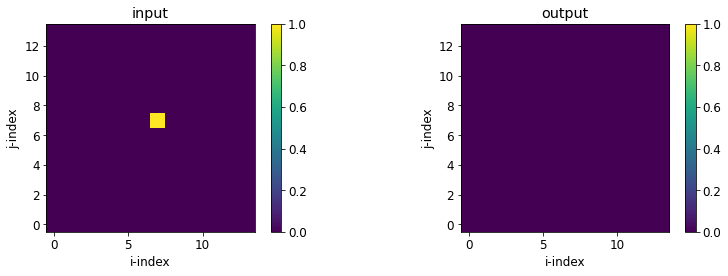

In [4]:
# define input and output storage (we use a halo of nhalo points in ij-direction)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
origin = (nhalo, nhalo, 0)

in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
out_field = in_field.copy()

in_field[nx//2 + nhalo, ny//2 + nhalo, 0] = 1.

# visualize storages
plot_two_ij_slices(in_field, out_field)

### Running computations

Executing stencil computations is as simple as a function call:

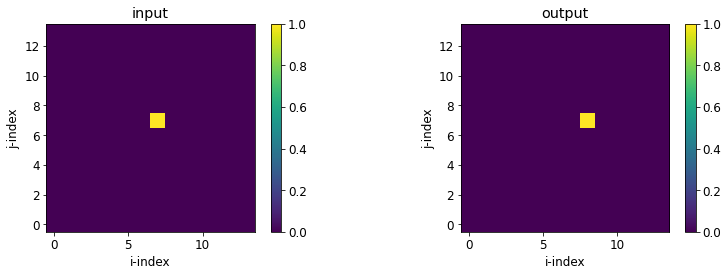

In [5]:
# run stencil
origin = (nhalo, nhalo, 0)
domain = (nx, ny, nz)
shift_by_one(b=in_field, a=out_field, origin=origin, domain=domain)

# visualize results
plot_two_ij_slices(in_field, out_field)

The stencil object retains the same signature of its definition function and adds two additional parameters: `origin` and `domain`. The former specifies the first element of the output field `out_field` for which a new value should be computed. In other terms, it represents the origin of the region of application (or **compute domain**) of the stencil. The extent of the region of application is determined by `domain`.

The binding between the symbols used within the definition function and the storage buffers happens at invocation time. This implies that the stencil object is not bound to any given grid size. Therefore the same stencil computation can be run on different grids and/or computation domains without any re-compilation.

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px"> A domain-specific lanugage restricts what a user can do and only a restricted set of operations is legal inside a stencil function. Try inserting <code>a = np.sqrt(b[-1, 0, 0])</code> and recompiling the stencil and see what happens.</li>
        <li style="margin-bottom: 10px"> Change the stencil to shift in negative i-direction as well as in positive or negative j-direction and check the results. Try accessing an offet in k-direction and check the error message when running the stencil.</li>
        <li style="margin-bottom: 10px"> Initialize the input field with random numbers instead and check that only the compute domain of the output field is computed. </li>
        <li style="margin-bottom: 10px"> The compute domain is defined by the <code>origin</code> and <code>domain</code> arguments to a stencil. Extend the compute domain to the full domain (including the halo-points) and rerun the stencil. This leads to an error message. Do you understand why? Try extending the compute domain to the maximum possible. </li>
    </ol>
</div>

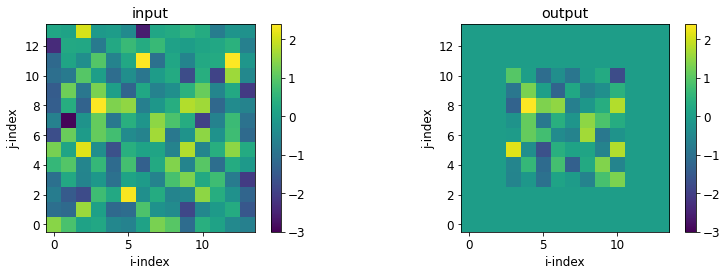

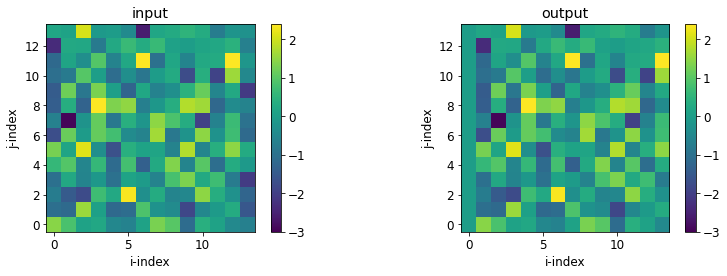

In [6]:
# REMOVE - solution to 3.
in_field = gt4py.storage.from_array(
    np.random.randn(shape[0], shape[1], nz), backend, origin, shape, dtype=np.float64
)
shift_by_one(b=in_field, a=out_field, origin=origin, domain=domain)
plot_two_ij_slices(in_field, out_field)

# REMOVE - solution to 4.
origin = (1, 0, 0)
domain = (nx + 2*nhalo - 1, ny + 2*nhalo, nz)
shift_by_one(b=in_field, a=out_field, origin=origin, domain=domain)
plot_two_ij_slices(in_field, out_field)

### Horizontal Laplacian

The horizontal Laplacian is probably on of the simplest "realistic" stencils. For example, the `del2_cubed()` subroutine in FV3 (see [here](http://academy.jcsda.org/doxygen-example/dyn__core__adm_8_f90_source.html#l08669)) implements a horizontal Laplacian on the cubed sphere for numerical filtering. For the sake of simplicity, we will assume a regular, Cartesian grid with constant grid spacing $\Delta x = \Delta y = 1$ and use simple 2nd-order finite differences.

\begin{eqnarray}
\Delta u && = && \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \\[2ex]
\Delta u_{i,j} && \approx && \frac{u_{i-1,j} - 2\,u_{i,j} + u_{i+1,j}}{\Delta x^2} + \frac{u_{i,j-1} - 2\,u_{i,j} + u_{i,j+1}}{\Delta y^2} \\[2ex]
&& = && -4\,u_{i,j} + u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} \\[2ex]
\end{eqnarray}

This example will be used and expanded upon throughout the workshop to introduce additional DSL concepts. We start by implementing the defintion function. This time we will not use the `@gtscript.stencil` decorator to directly compile the stencil but rather compile it explicitly afterwards.

In [8]:
def laplacian_def(in_field: Field[np.float64], out_field: Field[np.float64]):
    pass # TODO - implement Laplacian stencil using DSL language

# REMOVE - solution to 1.
def laplacian_def(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        out_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        
# REMOVE - solution to 2.
def laplacian_def(in_field: Field[np.float64], out_field: Field[np.float64], *, coeff: np.float64):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

### Compiling a stencil

GT4Py can generate high-performance implementations of a stencil starting from its definition function. The GT4Py pipeline relies on so-called **backends** to produce native implementations for different platforms. The `"debug"` and `"numpy"` backends are suitable for early testing and prototyping purposes.

We use the expression **stencil compilation** to indicate the joint procedure which generates (and possibly compiles) the stencil code on-the-fly, creates Python bindings for it and import these bindings in the current scope. In the shift-by-one example above, compilation was done implicitly through the decorator. Here, the stencil compilation is accomplished by the function `gtscript.stencil()`

Currently available backend options are:
* `"debug"`: produces Python code which explicitly iterates over all grid points
* `"numpy"`: produces Python code which adopts the array programming (i.e. vectorized) syntax using NumPy
* `"gtx86"`: produces C++ GridTools-based code devised for a generic multi-core x86 CPUs
* `"gtmc"`: produces C++ GridTools-based code devised specifically for many-core CPUs such as Xeon Phi
* `"gtcuda"`: produces C++ GridTools-based code devised for NVIDIA GPUs

`gtscript.stencil()` returns a callable object (henceforth referred to as **stencil object**) which exposes a high-level entry-point to the generated code.

The generated code, binaries and bindings are cached for future usages. If you prefer not to rely on this caching mechanism, you should pass the keyword argument `rebuild=True` to `gtscript.stencil()`.

In [9]:
backend = "numpy"
laplacian = None # TODO - compile stencil

# REMOVE - solution to 1.
backend = "numpy"
laplacian = gtscript.stencil(backend, laplacian_def)

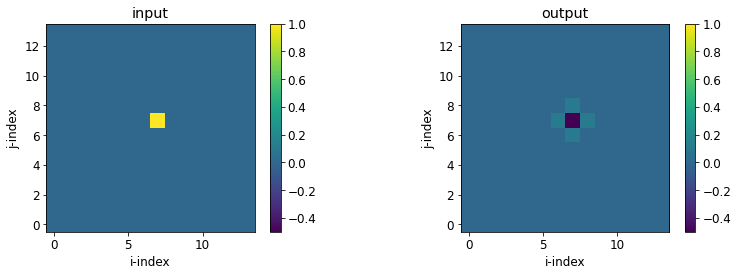

In [10]:
# define input and output storage (we use a halo of nhalo points in ij-direction)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
origin = (nhalo, nhalo, 0)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
out_field = in_field.copy()
in_field[nx//2 + nhalo, ny//2 + nhalo, 0] = 1.

# apply stencil
origin = (nhalo, nhalo, 0)
domain = (nx, ny, nz)
# TODO - remove coeff below!
laplacian(in_field=in_field, out_field=out_field, coeff=0.125, origin=origin, domain=domain)

# visualize results
plot_two_ij_slices(in_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li stype="margin-bottom: 10px"> If you have not already done so, implement the Laplacian stencil definition function above. Insert the required command to compile and run the stencil. Check the result.</li>
        <li style="margin-bottom: 10px"> Stencil functions also accept scalar arguments. These have to be keyword arguments. Add a coefficient <code>coeff: np.float64</code> to the end argument list. Separated from the Field arguments using a asterisk <code>... , *, coeff: np.float64</code>. Multiply the result of the discretized Laplacian with the coefficient in the stencil definition function. Try calling the stencil with different values (e.g. <code>coeff=0.</code> or <code>coeff=1.</code> to validate your implementation.</li>
        <li style="margin-bottom: 10px"> Recompile the stencil with the <code>"debug"</code> and <code>"gtx86"</code> backends and check that the result is still the same. Try adding the <code>verbose=True</code> keyword argument to `gtscript.stencil()` command when compiling for the <code>"gtx86"</code> backend to see what's going on. The generated code and object files are stored in the <code>.gt_cache</code> directory and can be inspected. Logon to orion using SSH and take a look at the generated code for the different backends.</li>
    </ol>
</div>

### Performance

The main goal of using a domain-specific language instead of "just" Python is to find a better balance between performance, portability and productivity. Several other Python frameworks exists which translate Python fucntions to optimized machine code at runtime, for example [Cython](https://cython.org), [Numba](https://numba.pydata.org), or [Devito](https://www.devitoproject.org). All of these frameworks make provide a different subset of domain-specific or Python features and make a unique compromise between generality, optimization and speed.

In order to make a basic performance comparison, we need to consider a more realistic domain size. We choose a domain size of 192 x 192 horizontal gridpoints and 79 vertical levels. On the dual-socket Skylake nodes of Orion this would correspond to approximately 32 x 32 horizontal gridpoints per core, which seems like a realistic setup for fine-resolution simulations.

The `"gtx86"` backend uses two-dimensional blocking in the ij-direction using OpenMP threads. 

In [11]:
ni, nj, nk = 192, 192, 79

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li stype="margin-bottom: 10px"> Loop over the <code>"numpy"</code>, <code>"gtx86"</code>, and <code>"gtmc"</code> backends. Create two storages with the above sizes (add <code>nhalo</code> halo lines on each side) for the correct backend. Fill the input storage with random values, the output storage with zeros. Compile the Laplacian from above with the correct backend. Use <code>%timeit</code> to time the execution of the Laplacian stencil.</li>
        <li stype="margin-bottom: 10px"> When running stencils, they provide some basic runtime information with the <code>exec_info</code> keyword argument. Initialize an empty dictionary <code>exec_info={}</code> and pass it as a keyword argument to the stencil. Inspect the contents <code>exec_info</code> after the stencil call. Can you confirm the time measurements of <code>%timeit</code>? Estimate the overhead of Python for the <code>"gtx86"</code> backend.</li>
    </ol>
</div>

In [12]:
# REMOVE - solution 1. and 2.
for backend in ["numpy", "gtx86", "gtmc"]:
    print(f"Running with {backend} backend...")

    in_field = gt4py.storage.from_array(
        np.random.randn(ni + 2*nhalo, nj + 2*nhalo, nk), backend, (nhalo, nhalo, 0), (ni + 2*nhalo, nj + 2*nhalo, nk), dtype=np.float64
    )
    out_field = 0. * in_field.copy()

    laplacian = gtscript.stencil(backend, laplacian_def)
    
    fields = {"in_field": in_field, "out_field": out_field}
    scalars = {"coeff": 0.125}
    exec_info = {}
    
    %timeit laplacian(**fields, **scalars, origin=(nhalo, nhalo, 0), domain=(ni, nj, nk), exec_info=exec_info)
    
    call_time = exec_info['call_end_time']-exec_info['call_start_time']
    run_time = exec_info['run_end_time']-exec_info['run_start_time']
    print(f"  call_time = {call_time * 1000.} ms")
    print(f"  run_time = {run_time * 1000.} ms")
    print(f"  overhead = {(call_time - run_time)*1000.} ms")
    print("")


Running with numpy backend...
23 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
  call_time = 22.9239109903574 ms
  run_time = 22.612331435084343 ms
  overhead = 0.31157955527305603 ms

Running with gtx86 backend...
3.61 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
  call_time = 3.5787327215075493 ms
  run_time = 3.2709846273064613 ms
  overhead = 0.30774809420108795 ms

Running with gtmc backend...
5.11 ms ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
  call_time = 5.076372064650059 ms
  run_time = 4.731736145913601 ms
  overhead = 0.3446359187364578 ms

